In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np
#from stop_word_list import *
from nltk.corpus import stopwords
import cleantext
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['us', 'aa', 'told', 'said', 'get', 'never', 'american', 'delta', 'southwest', 'south', 'west', 'would', 
                   'next', 'even', 'one', 'back', 'first', 'like', 'could', 'great', 'good', 'bad', 'worst', 'ever',
                   'airlines', 'airline', 'flight', 'fly', 'flights', 'flying', 'way', 'also', 'got', 'made', 'airport',
                   'go', 'people', 'call', 'home', 'day', 'asked', 'son', 'two', 'three', 'four', 'five', 'make', 'slc',
                   'many', 'nice', 'love', 'another', 'area', 'always', 'well', 'easy', 'best', 'went', 'much', 'use',
                   'going', 'really', 'know', 'since', 'knowing', 'knows', 'knew', 'little', 'give', 'again', "don't"])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#Neg After
df = pd.read_csv('/Path/to_topicmodel/neg_after.csv', error_bad_lines=False);
clean_reviews = df.drop(columns=['compound', 'Date', 'Date.1', 'Rating', 'Title', 'scores', 'compound.1'], axis=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.Review])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in clean_reviews.Review])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True 
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = clean_reviews.copy()
reviews_w_ngrams.Review = reviews_w_ngrams.Review.map(lambda x: replace_ngram(x))
reviews_w_ngrams = reviews_w_ngrams.Review.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_words and len(word) > 2])
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

final_reviews = reviews_w_ngrams.map(noun_only)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
dictionary = corpora.Dictionary(final_reviews)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20


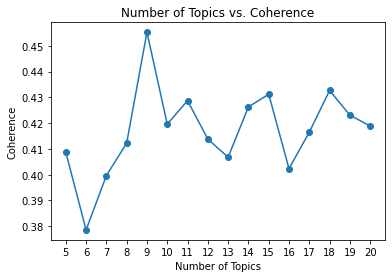

In [8]:
''''
coherence = []
for k in range(5,21):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()
'''

In [9]:
#try 9 and 17 topics

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=9, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

ldamodel.show_topics(9, num_words=15, formatted=False)
pprint(ldamodel.print_topics())

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"time" + 0.008*"plane" + 0.008*"travel" + 0.006*"canceled" + '
  '0.006*"delayed" + 0.006*"flight." + 0.005*"hour" + 0.005*"customer" + '
  '0.005*"waiting" + 0.005*"ticket"'),
 (1,
  '0.017*"mask" + 0.007*"class" + 0.007*"seat" + 0.007*"time" + '
  '0.004*"attendant" + 0.004*"change" + 0.004*"family" + 0.004*"wearing" + '
  '0.004*"pay" + 0.004*"someone"'),
 (2,
  '0.016*"time" + 0.014*"plane" + 0.010*"line" + 0.010*"check" + 0.008*"bag" + '
  '0.007*"gate" + 0.007*"connecting" + 0.007*"took" + 0.006*"experience" + '
  '0.006*"missed"'),
 (3,
  '0.014*"time" + 0.010*"booked" + 0.009*"delayed" + 0.009*"cancelled" + '
  '0.009*"hotel" + 0.008*"trip" + 0.008*"customer_service" + 0.007*"called" + '
  '0.007*"hour" + 0.007*"changed"'),
 (4,
  '0.006*"time" + 0.005*"ticket" + 0.005*"plane" + 0.004*"experience" + '
  '0.004*"travel" + 0.004*"customer_service" + 0.004*"check" + 0.004*"trip" + '
  '0.004*"put" + 0.003*"service"'),
 (5,
  '0.011*"seat" + 0.008*"boarding" + 0.008*"

In [11]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda(doc_term_matrix, num_topics=17, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 10000, eval_every = None, random_state=0)

ldamodel2.show_topics(17, num_words=15, formatted=False)
pprint(ldamodel.print_topics())

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [10]:
topic_data =  pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
